In [1]:
# Suggestion
# Make this grad engine for Tensors rather than scalars
# Use Numpy to implement your multi-dim primitive objects and its jacobian matrices
# Incorporate functions: add, sub, mul, div, relu, sigmoid, min, max, 
# Take care of cases where a node would split into 2 components when moving forward then during backprop 2 gradients would flow back to this node
# and in this case the gradients add up to be the total upstream gradient reaching this node


In [2]:
# Sanity Checks:

# # Gradient of a vector is the same shape as the vector
# Check analytically simplified gradients with step approximation (f(x+h) - f(x)) / h 

In [3]:
# Sundar Sundar Computation Graphs

from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    # Improved styling
    dot.attr('node', shape='record', style='filled', fillcolor='lightblue', color='black', fontcolor='black', fontsize='12', fontname='Helvetica')
    dot.attr('edge', color='gray', arrowsize='0.8', fontsize='10')

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Create a rectangular node with improved styling
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad))
        if n._op:
            # Create a diamond-shaped node for operations with distinct styling
            dot.node(name=uid + n._op, label=n._op, shape='diamond', style='filled', fillcolor='orange')
            # Connect this operation node to its result node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect input nodes to the operation node
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [4]:
from micrograd.engine import Value #This is Karpathy's Micrograd

In [5]:
a = Value(-4.0)
b = Value(2)
c = a+b
d = a*b + b**3
c += c + 1
c += c + 1 + (-a)
d += d*2 + (b+a).relu()
d += d*3 + (b-a).relu()
e =  c-d
f = e**2
g = f/2.0
g += 10.0/f
print(g.data)
g.backward()
print("dg/da = ",a.grad)
print(type(a))

24.70408163265306
dg/da =  138.8338192419825
<class 'micrograd.engine.Value'>


In [6]:
# Our Quant = mini torch.tensor type object
# Quant Class definition
import math
class Quant:
    def __init__(self, data,_children =(),_op = '',label = f'' ):
        self.data =  data
        self._backward = lambda : None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Quant(data = {self.data},label:{self.label})"
    
    def __add__(self,other):
        other = other if isinstance(other,Quant) else Quant(other)
        out = Quant(data=self.data +other.data,_children = (self,other),_op = '+')
        
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0* out.grad
            
        out._backward = _backward
        
        return out
    def __radd__(self,other):
        return (self + other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Quant) else Quant(other)
        
        out = Quant(data = self.data*other.data,_children=(self,other),_op='*')
        
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self,other):
        return (self * other)
    
    def __truediv__(self,other):
        return (self * other**(-1))
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __pow__(self,other):
        ## Please only give other param to be float or int, why was this written this way? I will change it once the project is complete
        # for two nodes say x and y, if we compute d(x^y)/d(x), its simple y*x^(y-1)
        # but when it is d(x^y)/d(y) i.e when gradient flows back to the other node which will be x^y*log(y), we will have to 
        # incorporate logarithms with different bases, 
        # I will do it but please give me some time, karpathy didnt do it, but I will and I need time. 
        # When you actually change this code when other will be a quant object, make sure you give proper children parameters, rn its none
        # Because when gradients flow back, it only flows back to the unary connected node before it and other is just scalar so there is
        # no node for other in computation graph (FOR NOW)
        assert isinstance(other , (int,float))
        out = Quant(self.data ** other,_children=(self,),_op="pow")
        def _backward():
            self.grad += out.grad * other * (self.data**(other-1))
        return out
    
    def exp(self):
        out = Quant(data=math.exp(self.data),_children=(self,),_op='exp')

        def _backward():
            self.grad += out.grad*out.data
        self._backward = _backward
        return out
       
        
        
        
        
    def sigmoid(self,):
        sigmoid = 1.0/(1.0+math.exp(self.data)+1.0)
        out = Quant(data=sigmoid,_children=(self,),_op='sigmoid')
        
        def _backward():
            self.grad += out.grad * sigmoid * (1-sigmoid)
        
        out._backward = _backward
        
        return out
            
    def tanh(self,):
        tanh = (math.exp(self.data) - math.exp(-self.data))/(math.exp(self.data)+math.exp(-self.data))
        out = Quant(data=tanh,_children =  (self,),_op = 'tanh')
        
        def _backward():
            self.grad += (1-tanh**2)*out.grad 
        
        out._backward = _backward
        return out
    
    
    def backward(self,):
        # Routine for topo-sort of nodes
        topo= []
        visited = set()
        def topo_sort(vertex):
            if vertex not in visited:
                visited.add(vertex)
                for child in vertex._prev:
                    topo_sort(child)
                topo.append(vertex)
        topo_sort(self)
        
        # This is the 'processing' part
        for node in reversed(topo):
            node._backward()
        print("*****The Topo Sort for graph is ******")
        print(topo)        
            

*****The Topo Sort for graph is ******
[Quant(data = 1,label:), Quant(data = 2,label:), Quant(data = -1,label:b), Quant(data = 2,label:a), Quant(data = -2,label:c), Quant(data = 0.4683105308334812,label:d), Quant(data = 8,label:e), Quant(data = 3.7464842466678494,label:f), Quant(data = 7.492968493335699,label:g), Quant(data = 1795.373744285921,label:i), Quant(data = 1796.373744285921,label:), Quant(data = 0.000556677029588579,label:), Quant(data = -1,label:), Quant(data = 1794.373744285921,label:), Quant(data = 0.9988866459408229,label:h)]


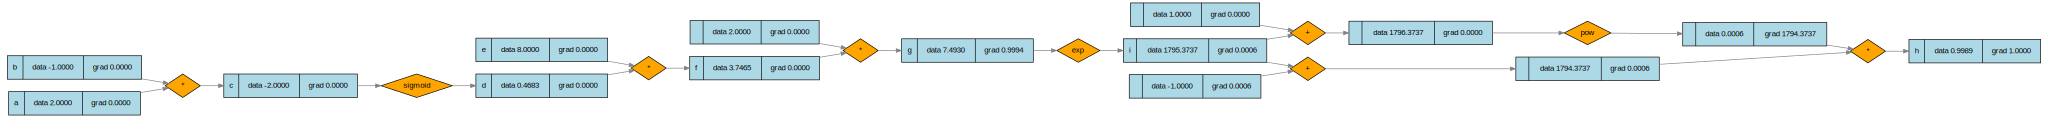

In [7]:
a = Quant(2,label='a')
b = Quant(-1,label='b')
c = (a*b); c.label = f'c'
d = c.sigmoid() ; d.label= f'd'
e = Quant(8,label='e')
f = d*e ; f.label = f'f'

g =2*f ; g.label = 'g'
i = g.exp() ; i.label = 'i'
h = (i-1) / (i+1) ; h.label = f'h'
h.grad = 1.0
h.backward()
draw_dot(h)

*****The Topo Sort for graph is ******
[Quant(data = -1,label:b), Quant(data = 2,label:a), Quant(data = -2,label:c), Quant(data = 0.4683105308334812,label:d), Quant(data = 8,label:e), Quant(data = 3.7464842466678494,label:f), Quant(data = 0.9988866459408229,label:g)]


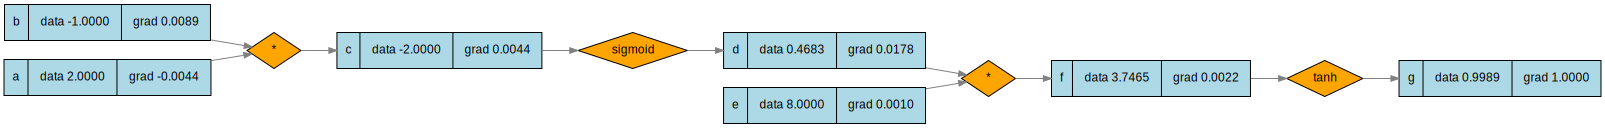

In [8]:
def lol():
    a = Quant(2,label='a')
    b = Quant(-1,label='b')
    c = (a*b); c.label = f'c'
    d = c.sigmoid() ; d.label= f'd'
    e = Quant(8,label='e')
    f= d*e ; f.label = f'f'
    #f =2*e ; f.label = 'f'
    #g = (f.exp()-1) / (f.exp()+1) ; g.label = f'g'
    g = f.tanh() ; g.label = f'g'
    g.grad = 1.0
    g.backward()
    display(draw_dot(g))
lol()